In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d kmader/pulmonary-chest-xray-abnormalities

100% 4.08G/4.09G [01:40<00:00, 55.0MB/s]
100% 4.09G/4.09G [01:40<00:00, 43.7MB/s]


In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [7]:
!unzip -q pulmonary-chest-xray-abnormalities.zip

In [8]:
!unzip -q ChinaSet_AllFiles.zip -d chinaset

unzip:  cannot find or open ChinaSet_AllFiles.zip, ChinaSet_AllFiles.zip.zip or ChinaSet_AllFiles.zip.ZIP.


In [9]:
!unzip -q Montgomery.zip -d montset

unzip:  cannot find or open Montgomery.zip, Montgomery.zip.zip or Montgomery.zip.ZIP.


In [10]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [11]:

root_dir = "/content/drive/My Drive/Hack In India/"
base_dir = root_dir + 'fastai-v3/'

In [12]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
from fastai.vision import *
from fastai.metrics import error_rate

In [14]:
bs = 64

In [15]:
path = Path("/content/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/")

In [16]:
fnames = get_image_files(path)
fnames.sort()
fnames[:5]

[PosixPath('/content/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0001_0.png'),
 PosixPath('/content/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0002_0.png'),
 PosixPath('/content/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0003_0.png'),
 PosixPath('/content/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0004_0.png'),
 PosixPath('/content/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/CHNCXR_0005_0.png')]

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
def get_labels(file_path): return 'Normal' if '_0.png' in str(file_path) else 'Abnormal'
data = ImageDataBunch.from_name_func(path, fnames, label_func=get_labels, ds_tfms=get_transforms(), size = 224, bs=bs).normalize(imagenet_stats)

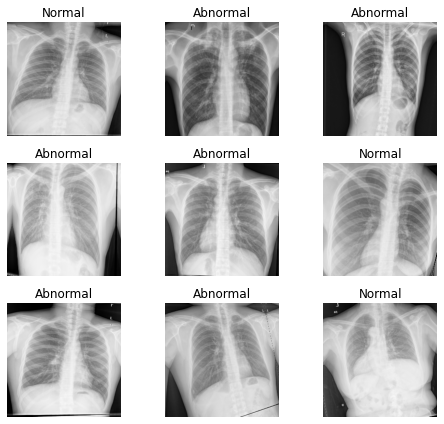

In [19]:
data.show_batch(rows=3, figsize=(7,6))

In [20]:
data.c,len(data.train_ds), len(data.valid_ds)

(2, 530, 132)

In [41]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [43]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.841549,0.870173,0.727273,01:28
1,0.833757,0.850798,0.696970,01:29
2,0.760322,1.060618,0.674242,01:30
3,0.698282,0.907776,0.689394,01:31
4,0.655502,0.760464,0.750000,01:32


In [44]:
learn.save('stage-1')

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

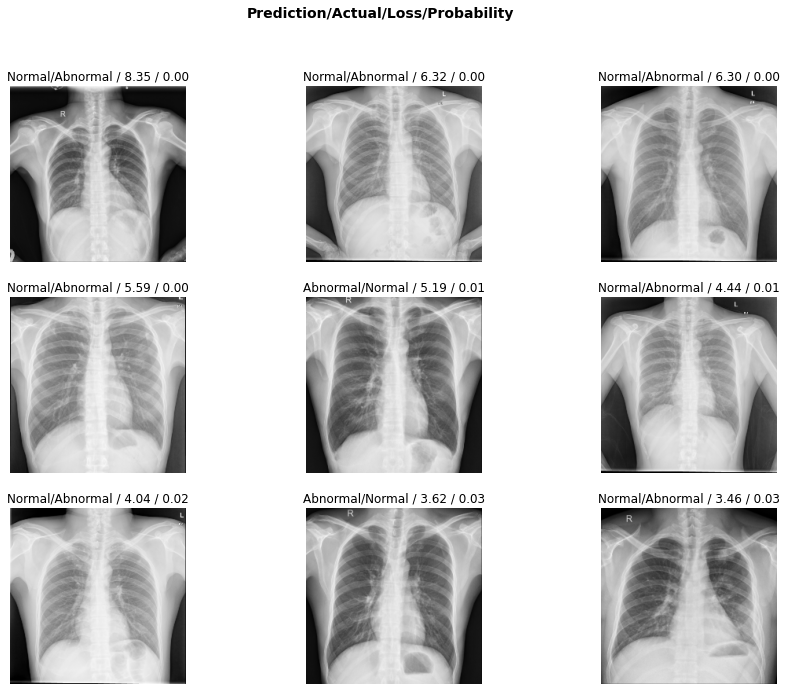

In [46]:
interp.plot_top_losses(9, figsize=(15,11))

In [47]:
learn.unfreeze()

In [48]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


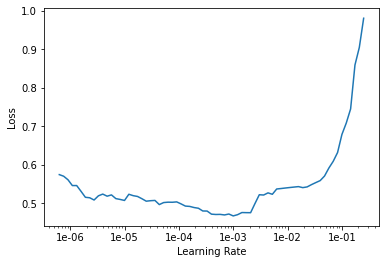

In [49]:
learn.recorder.plot()

In [50]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-06, 1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.559070,0.603765,0.810606,01:27
1,0.508843,0.590135,0.818182,01:27
2,0.478170,0.562835,0.840909,01:27
3,0.434333,0.576975,0.818182,01:26
4,0.421146,0.587471,0.818182,01:27


In [51]:
learn.save('stage-2', return_path=True)

PosixPath('/content/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/models/stage-2.pth')

In [52]:
learn.unfreeze()
learn.fit_one_cycle(10,max_lr=slice(1e-06, 1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.360803,0.569500,0.825758,01:27
1,0.380613,0.551430,0.810606,01:27
2,0.356670,0.549676,0.856061,01:28
3,0.364840,0.630902,0.803030,01:29
4,0.366579,0.543577,0.810606,01:30
5,0.335959,0.476384,0.840909,01:29
6,0.312392,0.472086,0.848485,01:30
7,0.299605,0.495069,0.856061,01:31
8,0.285824,0.501958,0.871212,01:31
9,0.274582,0.498052,0.871212,01:30


In [53]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


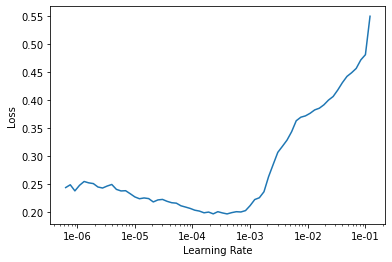

In [54]:
learn.recorder.plot()

In [55]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

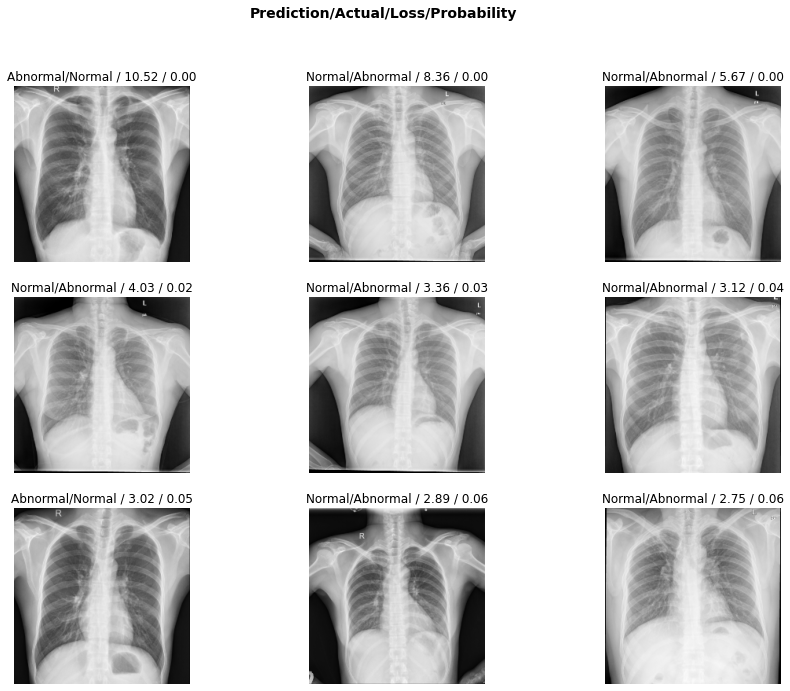

In [56]:
interp.plot_top_losses(9, figsize=(15,11))

In [57]:
learn.export(file="/content/resnet50.pkl")

In [58]:
path=learn.path
print(path)

/content/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png
